# Read PSL motion files

Clues:
```
04/28/2024 00:00 systron PSL (SN: 999)
0000009 0.002179841,-0.004321344,-0.007393281,0.1804913,-0.09683202,-3.639365,1
0000119 -0.002570751,-0.005,-0.002642688,0.01625653,-0.07443636,-3.662439,1
0000213 -0.002570751,-0.005,-0.0101079,0.008791309,-0.0181079,-3.700444,1
0000305 -0.01071462,-0.006357312,-0.005357312,-0.04889446,0.05382964,-3.749306,1
```
NOPE:
```
1 time
2 accx (m.s^-^2)
3 accy (m.s^-^2)
4 accz (m.s^-^2)
5 ratex (rad/s)
6 ratey (rad/s)
7 ratez (rad/s)
```
Correction:
```matlab
    accx = (+z(8,:)+0)./3.7756.*9.80;       % forward is positive - MotPak Y channel
    accy = (+z(7,:)+0)./3.8215.*9.80;       % to port is positive - MotPak X channel
    accz = (-z(9,:)+0)./3.7005.*9.80;       % up is positive
 

    ratex = (+z(5,:)+0)/0.025/180*pi;       % port up is positive phi - MotPak Y channel
    ratey = (+z(4,:)+0)/0.025/180*pi;       % bow down is positive theta - MotPak X channel
    ratez = (-z(6,:)+0)/0.025023/180*pi;    % bow to port is positive psi (right-handed)
```
The CORRECTED columns are
```
1 time
2 ratey (rad/s)     + bow down
3 ratex (rad/s)     + port up (broken for ASTRAL 2024 leg 1)
4 ratez (rad/s)     + bow to port
5 accy (m.s^-^2)    + to port
6 accx (m.s^-^2)    + forward
7 accz (m.s^-^2)    + up
```

In [1]:
# usings

using Revise
using Pkg; Pkg.activate(".")
using Dates
using Statistics
using DSP  # for filtering
using Interpolations

using Printf
using PyPlot

include("readers.jl")
using .NoaaDas # reads motion
using .DasGps  # reads heading
using .DasScs
using .ShipPosmv

  Activating project at `~/Projects/ASTRAL/mast`


In [2]:
# utility functions
m2n(x) = ismissing(x) ? NaN : x
pd = permutedims

"recursively call f n times: f^n(x)"
recurse(f, x, n::Integer) = n==0 ? x : recurse(f, f(x), n-1)

anom(x) = x .- mean(x)

square(n) = collect(ones(n)/n)
"n-point running mean, run forwards, back, forwards, back"
runningmean4(x, n) = recurse(x->filtfilt(square(n),x), x, 2)
"highpass filter from the 4-pass running mean"
highpass4(x, n) = x .- runningmean4(x, n)

"despiking filter"
function despike(x, n=240, tol=2)
    y = runningmean4(x, n)
    v = runningmean4((x.-y).^2, n) # running variance
    # id spikes outside tol*std dev of running mean
    b = ( (x.-y).^2 .> tol^2 .* v )
    spikes = findall(b)
    good = findall(.!b)
    # interpolate over spikes, assuming gridded data
    itp = interpolate((good,), x[good], Gridded(Linear()))
    z = copy(x)
    z[spikes] .= NaN
    innerspikes = spikes[first(good) .< spikes .< last(good)] #can be reinterpolated
    z[innerspikes] .= itp[innerspikes]
    return z
end



despike

In [3]:

#=
# general PSL DAS readers

# parameters for ASTRAL - feed defaults to functions
baseyear = 2024
mastdir = "./data/PSL/"
# ncolumn = 22 # change for different file types

"yearday from Date or DateTime"
yday(dt) = Dates.value(Date(dt) - Date(year(dt)-1,12,31))
yday(ddd::AbstractString) = parse(Int, ddd)

"return all filenames with prefix and date dt"
function get_das_filenames(prefix, yd::Integer, mastdir=mastdir)
    filter(startswith(prefix), 
           readdir(joinpath(mastdir, @sprintf("%03d",yd))))
end
function get_das_filenames(prefix, dt::Date, mastdir=mastdir)
    get_das_filenames(prefix, yday(dt), mastdir)
end
"return filenames with prefix matching hour of dt"
function get_das_filenames(prefix, dt::DateTime, mastdir=mastdir)
    hh = @sprintf("%02d", Dates.value(Hour(dt)))
    filter( endswith(hh*"_raw.txt"),
            get_das_filenames(prefix, Date(dt), mastdir) )
end

"return vector of full paths of all files with prefix and date"
function get_das_pathfiles(prefix, dt, mastdir=mastdir)
    joinpath.(mastdir,
              @sprintf("%03d",yday(dt)),
              get_das_filenames(prefix, dt, mastdir))
end

"Convert a PSL date to a DateTime."
function psldatetime(d::Date, hr::Integer, psltime::AbstractString)
    mm  = Minute(     parse(Int32, psltime[1:2]))
    SS  = Second(     parse(Int32, psltime[3:4]))
    sss = Millisecond(parse(Int32, psltime[5:7]))
    DateTime(Date(d)) + Hour(hr) + mm + SS + sss
end
function psldatetime(d::Date, hr::Integer=0, minute::Real=0)
    DateTime(Date(d)) + Hour(hr) + Minute(minute) + Second(second)
end
function psldatetime(yearday::Integer, hr::Integer=0; minute::Real=0, baseyear=baseyear)
    DateTime(baseyear-1,12,31) + Day(yearday) + Hour(hr) + Minute(minute)
end
# psldatetime(Date(2024,5,8), hr, "0606111")
# To get filename from the date, hour
# psldatefile(prefix, psldatetime(d, hr, psltime))

# file format default parameters
nheader = 1
# dt = DateTime(2024,5,8,11,0,0)
# pathfilename = get_das_pathfiles(prefix, dt::DateTime, mastdir=mastdir)

"read das data and put in a dictionary"
function read_das_dict(pathfilename, keys;
    nheader=nheader,
    nsample=sum(countlines.(pathfilename) .- nheader),
    ncolumn=length(keys)-1 ) # default columns in data excluding datestamp

    # read data from file
    datatime, X = read_das_data(pathfilename; 
        nheader=nheader,
        nsample=nsample,
        ncolumn=ncolumn ) # specifying manages memory best
    
    return das_dict(keys, datatime, X) # returns dict
end

parseblank2missing(T, s) = isempty(s) ? missing : parse(T, s)

"read and parse one das data file"
function read_das_data(pathfilename::AbstractString;
    nheader=1,
    nsample=countlines(pathfilenames) - nheader, 
    ncolumn=30 )

    # trivially iterate over 1-vector
    dt, X = read_scs_data(pathfilename[1:1]; 
        nheader=nheader, nsample=nsample, ncolumn=ncolumn )
    return dt, X
end

"read and concatenate data from multiple files"
function read_das_data(pathfilename::Vector{<:AbstractString};
    nheader=1,
    nsample=sum( countlines.(pathfilenames) - nheader ),
    ncolumn=30 ) # data, not including timestamp

    # preallocate the data
    # psltime = Vector{String}(undef, nsample) # will point to data as it is read
    psldt = Vector{DateTime}(undef, nsample) # will point to data as it is read
    X = Array{Union{Float32,Missing}, 2}(undef, nsample, ncolumn)
    fill!(X, missing)

    nl = 0
    maxcol=0
    for pfile in pathfilename
        # find hour from the filename
        shortfilename = last(splitpath(pfile))
        ddd = shortfilename[end-12:end-10]
        basedt = Date(baseyear-1,12,31) + Day(yday(ddd))
        hr = parse(Int32, shortfilename[end-9:end-8])

        open(pfile) do file
            for _ in 1:nheader
                readline(file) # skip header
            end
            for line in readlines(file)
                nl += 1
                splt = split(line, r"[\s,]+")

                nx = min(ncolumn, length(splt[2:end]))
                if nx > 0 # skip empty lines
                    psltime = splt[1]
                    psldt[nl] = psldatetime(basedt, hr, psltime)

                    dataline = try
                        parseblank2missing.(Float32, splt[2:end])
                    catch
                        error("failed to parse: $(splt[2:end])")
                    end
                    maxcol = max(maxcol, nx) # data in longest line
                    X[nl, 1:nx] .= dataline[1:nx]
                end
            end
        end
    end

    return psldt[1:nl], X[1:nl, 1:maxcol]
end

"assign data to a dict of keys"
function das_dict(keys, datatime, X)
    D = Dict{eltype(keys), Any}()

    # special DateTime
    D[keys[1]] = datatime 
    # fill rest of dictionary
    for (ik, ky) in enumerate(keys[2:end])
        D[ky] = X[:, ik]
    end
    return D
end

"compute the decimal hour of day from a datetime"
function decimal_hour(dt::DateTime)::Float64
    hour = Dates.hour(dt)
    minute = Dates.minute(dt)
    second = Dates.second(dt)
    millisecond = Dates.millisecond(dt)
    
    # Calculate the decimal hour
    decimal_hour = hour + minute / 60 + second / 3600 + millisecond / 3600000
    return decimal_hour
end
=#

In [4]:
dt = Date(2024,5,23)
motkeys = [:time,
           :ratey, # (rad/s)      + bow down
           :ratex, # (rad/s)      + port up (broken for ASTRAL 2024 leg 1)
           :ratez, # (rad/s)      + bow to port
           :accy,  # (m.s^-^2)    + to port
           :accx,  # (m.s^-^2)    + forward
           :accz ] # (m.s^-^2)    + up"""))
Mot = read_das_dict(get_das_pathfiles("mot", dt), motkeys; ncolumn=length(motkeys)-1)

7-element Vector{Symbol}:
 :time
 :ratey
 :ratex
 :ratez
 :accy
 :accx
 :accz

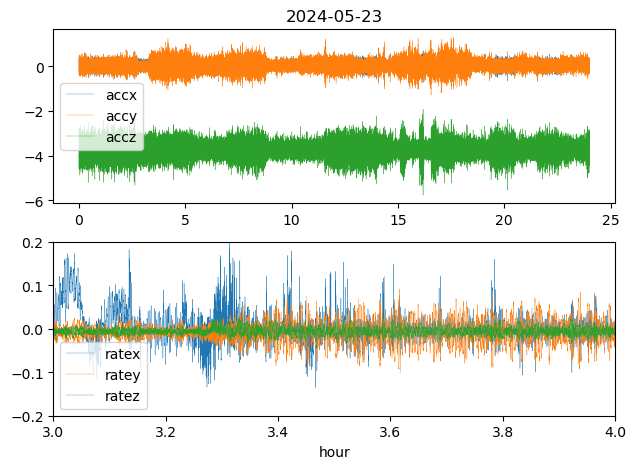

In [5]:
dh = m2n.(decimal_hour.( Mot[:time] ))
dtf = Dates.format(Mot[:time][5], dateformat"yyyy-mm-dd")

clf
subplot(2,1,1)
for k in [:accx, :accy, :accz]
    plot(dh, Mot[k], label=String(k), linewidth=0.25)
end
legend(frameon="false")
title(dtf)

subplot(2,1,2)
for k in [:ratex, :ratey, :ratez]
    plot(dh, Mot[k], label=String(k), linewidth=0.25)
end
legend(frameon="false")
xlabel("hour")

tight_layout()
xlim([3,4])
ylim([-0.2, 0.2])
savefig("mot_fix_20240523_03.png")

## Roll angular rate (ratex) looks bad
Orson inspected "analogue filters" box 2024 May 23 03:00 UTC. 
Connections look tight.

Use 1 Hz roll from the NOAA Hemisphere GPS compass, or the ship's POSMV GPS gyro compass.

NOAA Hemisphere GPS roll is in the `hed` heading file.

In [6]:
Hed = read_hed_dict( get_das_pathfiles("hed", dt) )
deh(D) = m2n.(decimal_hour.( D[:time] ))
deh(Mot)


863999-element Vector{Float64}:
  2.0555555555555555e-5
  4.638888888888889e-5
  7.694444444444445e-5
  0.00010277777777777778
  0.0001288888888888889
  0.00015944444444444445
  0.00018555555555555556
  0.00021555555555555556
  0.00024166666666666667
  0.00027194444444444445
  0.00029805555555555553
  0.00032416666666666667
  0.00035444444444444445
  ⋮
 23.9996775
 23.999703611111112
 23.99973388888889
 23.999760000000002
 23.999785833333338
 23.999816388888892
 23.999842222222224
 23.999868333333335
 23.999898611111114
 23.999925
 23.999955000000003
 23.99998138888889

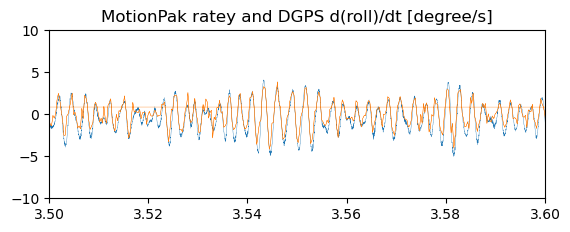

PyObject Text(0.5, 1.0, 'MotionPak ratey and DGPS d(roll)/dt [degree/s]')

In [7]:
# compare MotionPak and POSMV angular rates
clf()
subplot(2,1,1)
plot(deh(Mot), 180/pi*Mot[:ratey], linewidth=0.25)
# plot(deh(Mot), 180/pi*Mot[:ratex], linewidth=0.25)
# plot(deh(Hed).+(2/3600), Hed[:roll].+4, linewidth=0.25)
plot(deh(Hed)[1:end-1], -1.2*diff(Hed[:roll]), linewidth=0.25)
ylim([-10, 10]); xlim([3.5,3.6])
title("MotionPak ratey and DGPS d(roll)/dt [degree/s]")
# roll agrees and looks OK

In [8]:
# standard deviation of the 3 rate channels
( std(Mot[:ratey]), std(Mot[:ratex][dh.>4.0]), std(Mot[:ratez]) )

(0.026284376f0, 0.070294924f0, 0.008982695f0)

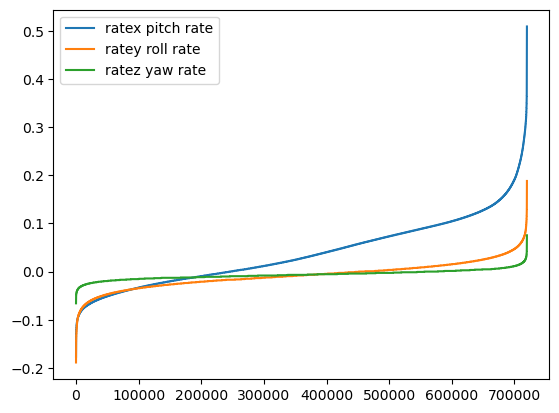

PyObject <matplotlib.legend.Legend object at 0x34527d060>

In [9]:
# histograms
plot(sort(Mot[:ratex][dh.>4.0]))
plot(sort(Mot[:ratey][dh.>4.0]))
plot(sort(Mot[:ratez][dh.>4.0]))
legend(["ratex pitch rate", "ratey roll rate", "ratez yaw rate"])
# pitch is malfunctioning, has spikes

In [10]:
# read POSMV
Pashr = read_pashr_dict(get_posmv_file("PASHR", dt))
# e.g. ./data/scs/NAV/POSMV-V5-PASHR-RAW_20240522-000001.Raw
pdh = decimal_hour.(Pashr[:time])
# pdh[end-10:end] .= unwrap.(pdh[end-10:end])

172802-element Vector{Float64}:
  0.00039527777777777776
  0.0005297222222222222
  0.0006686111111111111
  0.0008119444444444445
  0.000946388888888889
  0.0010897222222222224
  0.001228611111111111
  0.0013675
  0.001506388888888889
  0.0016452777777777778
  0.0017841666666666668
  0.001918888888888889
  0.0020619444444444444
  ⋮
 23.99876777777778
 23.998906666666667
 23.999045555555554
 23.999184444444445
 23.999323333333333
 23.999462222222224
 23.99959666666667
 23.999740000000003
 23.99987888888889
  1.7777777777777777e-5
  0.00015666666666666666
  0.0002955555555555556

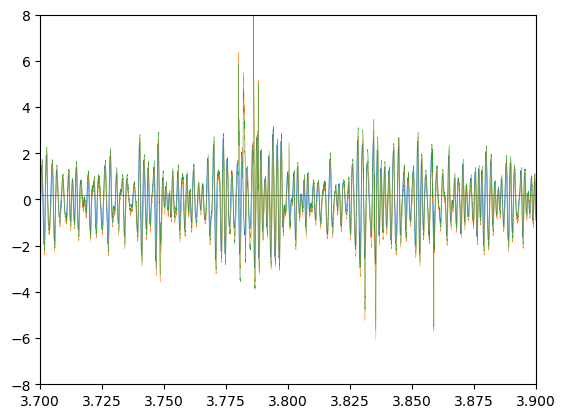

(-8.0, 8.0)

In [11]:
# use highpass filtering to center on 0

clf()
plot(pdh[2:end].+0.25/3600, -2.6 .* anom(diff(Pashr[:pitch])) , linewidth=0.5)
plot(deh(Mot), 180/pi*anom(Mot[:ratex]).+2, linewidth=0.25)
# plot(deh(Mot), 180/pi*highpass4(Mot[:ratex],180), linewidth=0.25)
xlim([3.7, 3.9])
ylim([-8, 8])

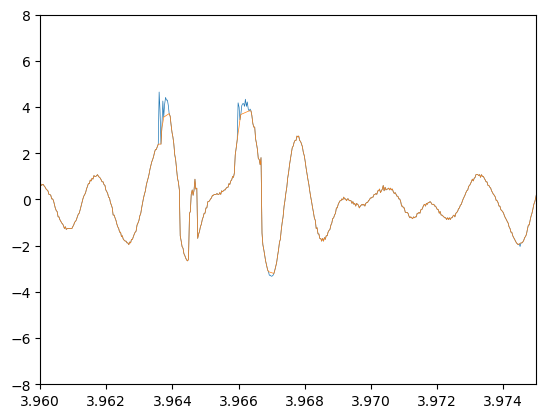

(-8.0, 8.0)

In [12]:
# now filter the pitch

clf()
# plot(pdh[2:end].+0.25/3600, -2.6 .* anom(diff(Pashr[:pitch])) , linewidth=0.5)
plot(deh(Mot), 180/pi*Mot[:ratex], linewidth=0.5)
plot(deh(Mot), 180/pi*despike(Mot[:ratex],180), linewidth=0.5)
# plot(deh(Mot), 180/pi*filterit(filterit(Mot[:ratex],180),180), linewidth=0.5)
# plot(deh(Mot), 180/pi*recurse(x->filterit(x,180),Mot[:ratex],2), linewidth=0.5)
xlim([3.96, 3.975])
ylim([-8, 8])

# spikes are not spikes but large jumps up, or failure to come down from
# maximum amplitude of a pitch cycle.


In [ ]:
# interpolate the POSMV pitch
function itp_pitchrate(dt::DateTime)
    ( Dates.value(dt) |> 
      interpolate( 
        Dates.value(Pashr[:time][2:end].-Millisecond(250)), 
        -diff(Pashr[:pitch])/0.5, 
        Gridded(Linear()))       )
end

clf()
plot(deh(Mot), -2.6 .* anom(diff(itp_pitch)) , linewidth=0.5)
plot(deh(Mot), 180/pi*Mot[:ratex], linewidth=0.5)
# plot(deh(Mot), 180/pi*despike(Mot[:ratex],180), linewidth=0.5)